In [0]:
#! pip uninstall -y tensorflow
#! pip uninstall -y tf-nightly
#! pip install -U tf-nightly-gpu
#! pip install tensorflow-model-optimization

In [0]:
import tensorflow as tf
import tempfile
import zipfile
import os
import h5py
import numpy as np
import glob
from numpy import linalg as LA
from scipy.stats import rankdata
from shutil import copyfile, move
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten , InputLayer
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [0]:
batch_size = 128
num_classes = 10
epochs = 10

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
x_test = x_test.reshape(x_test.shape[0], img_rows* img_cols)
input_shape = (img_rows* img_cols, )

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 784)
60000 train samples
10000 test samples


In [0]:
# Define the model(Sequential)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(128, input_shape = input_shape))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))


In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               100480    
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1290      
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


In [0]:
logdir = tempfile.mkdtemp()
callbacks = [tf.keras.callbacks.TensorBoard(log_dir=logdir, profile_batch=0)]

model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10
          )
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
469/469 [==============================] - 2s 3ms/step - loss: 0.3019 - accuracy: 0.9115
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.1260 - accuracy: 0.9617
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0911 - accuracy: 0.9722
Epoch 4/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0699 - accuracy: 0.9776
Epoch 5/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0616 - accuracy: 0.9800
Epoch 6/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0491 - accuracy: 0.9840
Epoch 7/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0425 - accuracy: 0.9863
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0360 - accuracy: 0.9880
Epoch 9/10
469/469 [==============================] - 2s 4ms/step - loss: 0.0318 - accuracy: 0.9896
Epoch 10/10
469/469 [==============================] - 2s 3ms/step - loss: 0.0299 - accuracy: 0.9898

In [0]:
#Save model
_, model_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, model_file, include_optimizer=False)

# Weight pruning

In [0]:
for k in [.25, .50, .60, .70, .80, .90, .95, .97, .99]:
  copyfile(model_file,"/tmp/orig.h5")
  f = h5py.File("/tmp/orig.h5",'r+')
  ranks = {}
  for l in list(f['model_weights'])[:-1]:
#   for l in ['dense', 'dense_1', 'dense_2', 'dense_3']:
    data = f['model_weights'][l][l]['kernel:0']
    w = np.array(data)
    ranks[l]=(rankdata(np.abs(w),method='dense') - 1).astype(int).reshape(w.shape)
    lower_bound_rank = np.ceil(np.max(ranks[l])*k).astype(int)
    ranks[l][ranks[l]<=lower_bound_rank] = 0
    ranks[l][ranks[l]>lower_bound_rank] = 1
    w = w*ranks[l]
    data[...] = w
  f.close()
  move("/tmp/orig.h5","/tmp/weight_"+str(k)+".h5")

# Neuron pruning

In [0]:
for k in [.25, .50, .60, .70, .80, .90, .95, .97, .99]:
  copyfile(model_file,"/tmp/orig.h5")
  f = h5py.File("/tmp/orig.h5",'r+')
  ranks = {}
  for l in list(f['model_weights'])[:-1]:
#   for l in ['dense', 'dense_1', 'dense_2', 'dense_3']:
    data = f['model_weights'][l][l]['kernel:0']
    w = np.array(data)
    norm = LA.norm(w,axis=0)
    norm = np.tile(norm,(w.shape[0],1))
    ranks[l] = (rankdata(norm,method='dense') - 1).astype(int).reshape(norm.shape)
    lower_bound_rank = np.ceil(np.max(ranks[l])*k).astype(int)
    ranks[l][ranks[l]<=lower_bound_rank] = 0
    ranks[l][ranks[l]>lower_bound_rank] = 1
    w = w*ranks[l]
    data[...] = w
  f.close()
  move("/tmp/orig.h5","/tmp/neuron"+str(k)+".h5")

In [0]:
files_weights = glob.glob('/tmp/weight*.h5')
files_weights.sort()
files_neuron = glob.glob('/tmp/neuron*.h5')
files_neuron.sort()
  
accuracy_weights = []
accuracy_neurons = []

for f in files_weights:
  restored_model = tf.keras.models.load_model(f,compile=False)
  restored_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])
  score = restored_model.evaluate(x_test, y_test, verbose=0)
  fl = h5py.File(f)
  params = 0
  accuracy_weights.append(score[1])



for f in files_neuron:
  restored_model = tf.keras.models.load_model(f,compile=False)
  restored_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy'])
  score = restored_model.evaluate(x_test, y_test, verbose=0)
  fl = h5py.File(f)
  params = 0
  accuracy_neurons.append(score[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


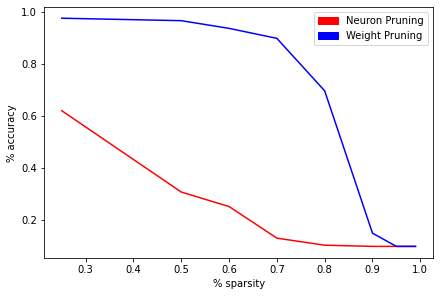

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.constrained_layout.use'] = True
plt.xlabel('% sparsity')
plt.ylabel('% accuracy')
red_patch = mpatches.Patch(color='red', label='Neuron Pruning')
blue_patch = mpatches.Patch(color='blue',label='Weight Pruning')
plt.legend(handles=[red_patch,blue_patch],loc='upper right')
plt.plot([.25, .50, .60, .70, .80, .90, .95, .97, .99],accuracy_neurons,color='red')
plt.plot([.25, .50, .60, .70, .80, .90, .95, .97, .99],accuracy_weights,color='blue')
plt.show()

In [0]:
pruned_keras_files = files_neuron+files_weights
_, zip1 = tempfile.mkstemp('.zip') 
with zipfile.ZipFile(zip1, 'w', compression=zipfile.ZIP_DEFLATED) as f:
  f.write(model_file)
print("Size of the unpruned model before compression: %.2f Mb" % 
      (os.path.getsize(model_file) / float(2**20)))
print("Size of the unpruned model after compression: %.2f Mb" % 
      (os.path.getsize(zip1) / float(2**20)))

for pruned_keras_file in pruned_keras_files:
  _, zip2 = tempfile.mkstemp('.zip') 
  with zipfile.ZipFile(zip2, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(pruned_keras_file)
  print("Size of the pruned model before compression: %.2f Mb" % 
        (os.path.getsize(pruned_keras_file) / float(2**20)))
  print("Size of the pruned model after compression: %.2f Mb" % 
        (os.path.getsize(zip2) / float(2**20)))



Size of the unpruned model before compression: 0.60 Mb
Size of the unpruned model after compression: 0.54 Mb
Size of the pruned model before compression: 0.60 Mb
Size of the pruned model after compression: 0.45 Mb
Size of the pruned model before compression: 0.60 Mb
Size of the pruned model after compression: 0.33 Mb
Size of the pruned model before compression: 0.60 Mb
Size of the pruned model after compression: 0.28 Mb
Size of the pruned model before compression: 0.60 Mb
Size of the pruned model after compression: 0.23 Mb
Size of the pruned model before compression: 0.60 Mb
Size of the pruned model after compression: 0.17 Mb
Size of the pruned model before compression: 0.60 Mb
Size of the pruned model after compression: 0.11 Mb
Size of the pruned model before compression: 0.60 Mb
Size of the pruned model after compression: 0.08 Mb
Size of the pruned model before compression: 0.60 Mb
Size of the pruned model after compression: 0.06 Mb
Size of the pruned model before compression: 0.60 M

In [0]:
import numpy as np
import keras
from keras import backend as K

model = keras.Sequential()
model.add(keras.layers.Dense(20, input_shape = (10, )))
model.add(keras.layers.Dense(5))
model.compile('adam', 'mse')

dummy_in = np.ones((4, 10))
dummy_out = np.ones((4, 5))
dummy_loss = model.train_on_batch(dummy_in, dummy_out)

def get_weight_grad(model, inputs, outputs):
    """ Gets gradient of model for given inputs and outputs for all weights"""
    grads = model.optimizer.get_gradients(model.total_loss, model.trainable_weights)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    output_grad = f(x + y + sample_weight)
    return output_grad


def get_layer_output_grad(model, inputs, outputs, layer=-1):
    """ Gets gradient a layer output for given inputs and outputs"""
    grads = model.optimizer.get_gradients(model.total_loss, model.layers[layer].output)
    symb_inputs = (model._feed_inputs + model._feed_targets + model._feed_sample_weights)
    f = K.function(symb_inputs, grads)
    x, y, sample_weight = model._standardize_user_data(inputs, outputs)
    output_grad = f(x + y + sample_weight)
    return output_grad




In [0]:
weight_grads = get_weight_grad(model, dummy_in, dummy_out)
output_grad = get_layer_output_grad(model, dummy_in, dummy_out)